## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

!pip install subword-nmt
!pip install nltk
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 1.2 MB 38.2 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.4.0
    Uninstalling torchtext-0.4.0:
      Successfully uninstalled torchtext-0.4.0


In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

from nltk.translate.bleu_score import corpus_bleu
import tqdm

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import matplotlib.ticker as ticker

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [3]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [4]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first=True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first=True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [5]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [6]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [6]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [8]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9218
Unique tokens in target (en) vocabulary: 6705


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'проживанием',
 'экскурсий',
 'комфорт',
 'forest',
 'электрическое',
 'nina',
 'фортуна',
 'евфразиева',
 'тюмени']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'russian', 'corte', 'cartagena', 'manoir', 'sanremo', 'mansions']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['this', 'property', 'features', 'both', 'free', 'wifi', 'and', 'free', 'private', 'parking', '.', 'a', 'flat', '-', 'screen', 'tv', 'is', 'provided', '.'], 'src': ['в', 'числе', 'удобств', 'каждого', 'номера', '—', 'собственная', 'ванная', 'комната', 'и', 'телевизор', 'с', 'плоским', 'экраном', 'и', 'спутниковыми', 'каналами', '.', 'на', 'территории', 'комплекса', 'предоставляется', 'бесплатный', 'wi', '-', 'fi', 'и', 'обустроена', 'бесплатная', 'частная', 'парковка', '.']}


Let's check the length distributions:

Length distribution in Train data


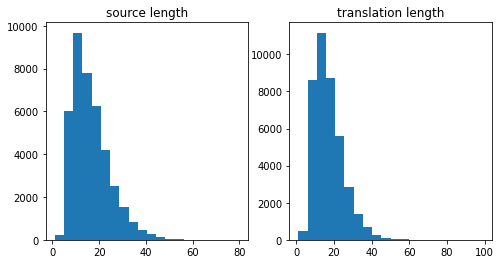

In [37]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


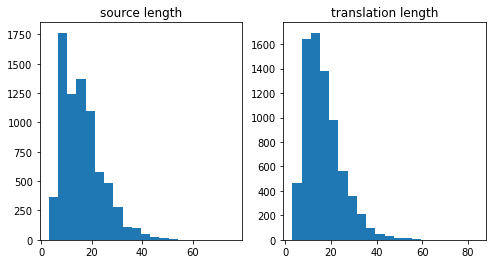

In [38]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

In [9]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key,
    sort_within_batch=True
)

In [12]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 54x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 47x128 (GPU 0)]
torch.Size([47, 128]) torch.Size([54, 128])


# 1. Baseline

In [10]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [11]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [12]:
def init_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9233, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6675, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6675, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,853,139 trainable parameters


In [15]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [16]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, transformer_or_cnn=False):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        if transformer_or_cnn:
            output, _ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
        else:
            output = model(src, trg)

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]
            
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            
            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [17]:
def evaluate(model, iterator, criterion, transformer_or_cnn=False):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            if transformer_or_cnn:
                output, _ = model(src, trg[:,:-1])
                output_dim = output.shape[-1]
                output = output.contiguous().view(-1, output_dim)
                trg = trg[:,1:].contiguous().view(-1)
            else:
                output = model(src, trg, 0) #turn off teacher forcing

                #trg = [trg sent len, batch size]
                #output = [trg sent len, batch size, output dim]

                output = output[1:].view(-1, output.shape[-1])
                trg = trg[1:].view(-1)

                #trg = [(trg sent len - 1) * batch size]
                #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

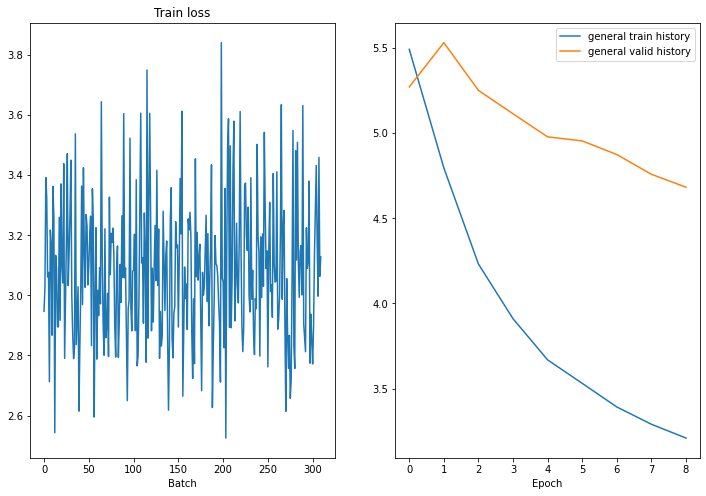

Epoch: 10 | Time: 1m 44s
	Train Loss: 3.085 | Train PPL:  21.871
	 Val. Loss: 4.679 |  Val. PPL: 107.651


In [21]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'baseline-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [31]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten
translate_sentence = utils.translate_sentence
display_attention = utils.display_attention
calculate_bleu = utils.calculate_bleu

In [23]:
batch = next(iter(test_iterator))

In [24]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: savoury options are available on request .
Generated: the can enjoy a drink at the bar .

Original: guests can enjoy the on - site bar .
Generated: the can enjoy a drink at the bar .



In [25]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:04, 13.82it/s]


In [26]:
bleu = corpus_bleu([[text] for text in original_text], generated_text)

print(f'BLEU score = {bleu*100:.2f}')

BLEU score = 12.45


Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

# 2. GRU + Attention

Улучшим baseline, заменив в нем LSTM на GRU и добавив механизм attention между энкодером и декодером

In [27]:
import GRU_with_Attention
Encoder = GRU_with_Attention.Encoder
Decoder = GRU_with_Attention.Decoder
Seq2Seq = GRU_with_Attention.Seq2Seq

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [29]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9218, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6705, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention()
    (out): Linear(in_features=1024, out_features=6705, bias=True)
  )
)

In [30]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,466,225 trainable parameters


In [31]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

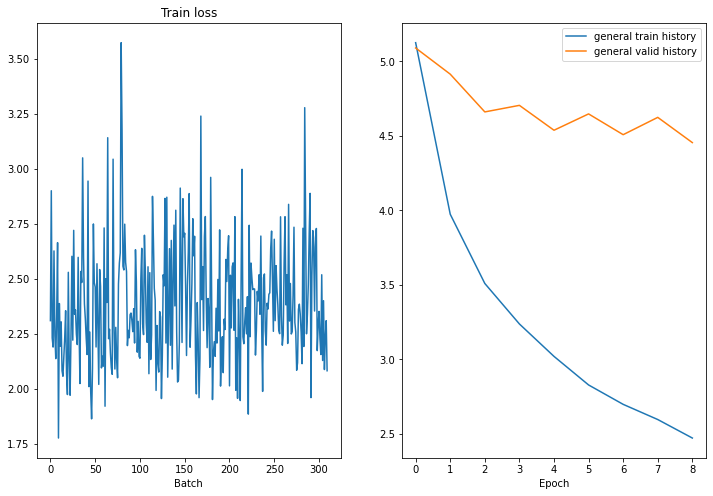

Epoch: 10 | Time: 2m 5s
	Train Loss: 2.385 | Train PPL:  10.854
	 Val. Loss: 4.584 |  Val. PPL:  97.903


In [32]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'gru-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [33]:
batch = next(iter(test_iterator))

In [34]:
for idx in [3,4]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a shared kitchen at the property .
Generated: shared kitchen is available .

Original: the 24 - hour front desk also provides basic business services like fax and photocopying .
Generated: there is a 24 - hour front desk at the property .



In [35]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:04, 12.74it/s]


In [36]:
bleu = corpus_bleu([[text] for text in original_text], generated_text)

print(f'BLEU score = {bleu*100:.2f}')

BLEU score = 22.72


Результат выше второго порога (20%)

# 3. Transformer
Использовал наработки из [Attention is All You Need](https://colab.research.google.com/github/happy-jihye/Natural-Language-Processing/blob/main/code/6_Attention_is_All_You_Need.ipynb)

In [33]:
import transformer
Encoder = transformer.Encoder
Decoder = transformer.Decoder
Seq2Seq = transformer.Seq2Seq

In [34]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [35]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [36]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,792,787 trainable parameters


In [37]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9233, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

In [38]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

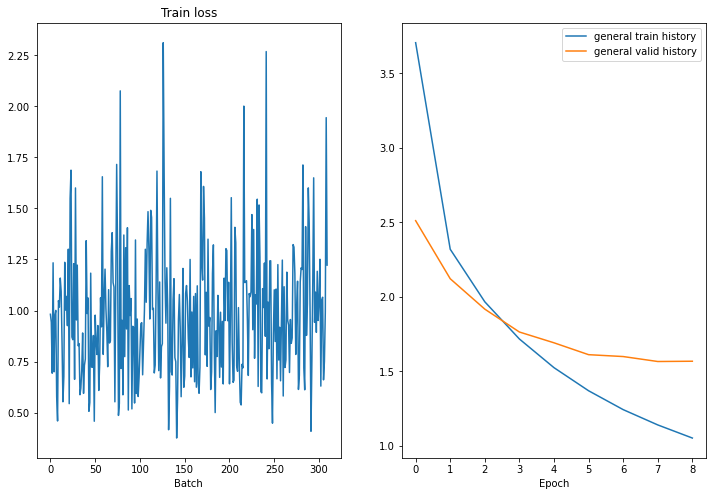

Epoch: 10 | Time: 0m 29s
	Train Loss: 0.980 | Train PPL:   2.665
	 Val. Loss: 1.579 |  Val. PPL:   4.852


In [42]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, True)
    valid_loss = evaluate(model, valid_iterator, criterion, True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [43]:
for idx in [5,6]:

    src = vars(train_data.examples[idx])['src']
    trg = vars(train_data.examples[idx])['trg']
    translation, attention = translate_sentence(src, SRC, TRG, model, device)

    print(f"RUS: {' '.join(src)}")
    print(f"ENG: {' '.join(trg)}")
    print(f"Model: {' '.join(translation)}")
    print()

RUS: в номерах мотеля есть телевизор с плоским экраном .
ENG: rooms include a flat - screen tv .
Model: rooms at the motel feature a flat - screen tv . <eos>

RUS: проживая в апартаментах anka , расположенных в поселке трстено , гости смогут готовить на собственной кухне и пользоваться бесплатным wi - fi .
ENG: apartment anka is a self - catering accommodation located in trsteno . freewifi access is available .
Model: located in <unk> , <unk> apartments offers self - catering accommodation with free wifi access in the kitchen . <eos>



Можно изучить маски attention

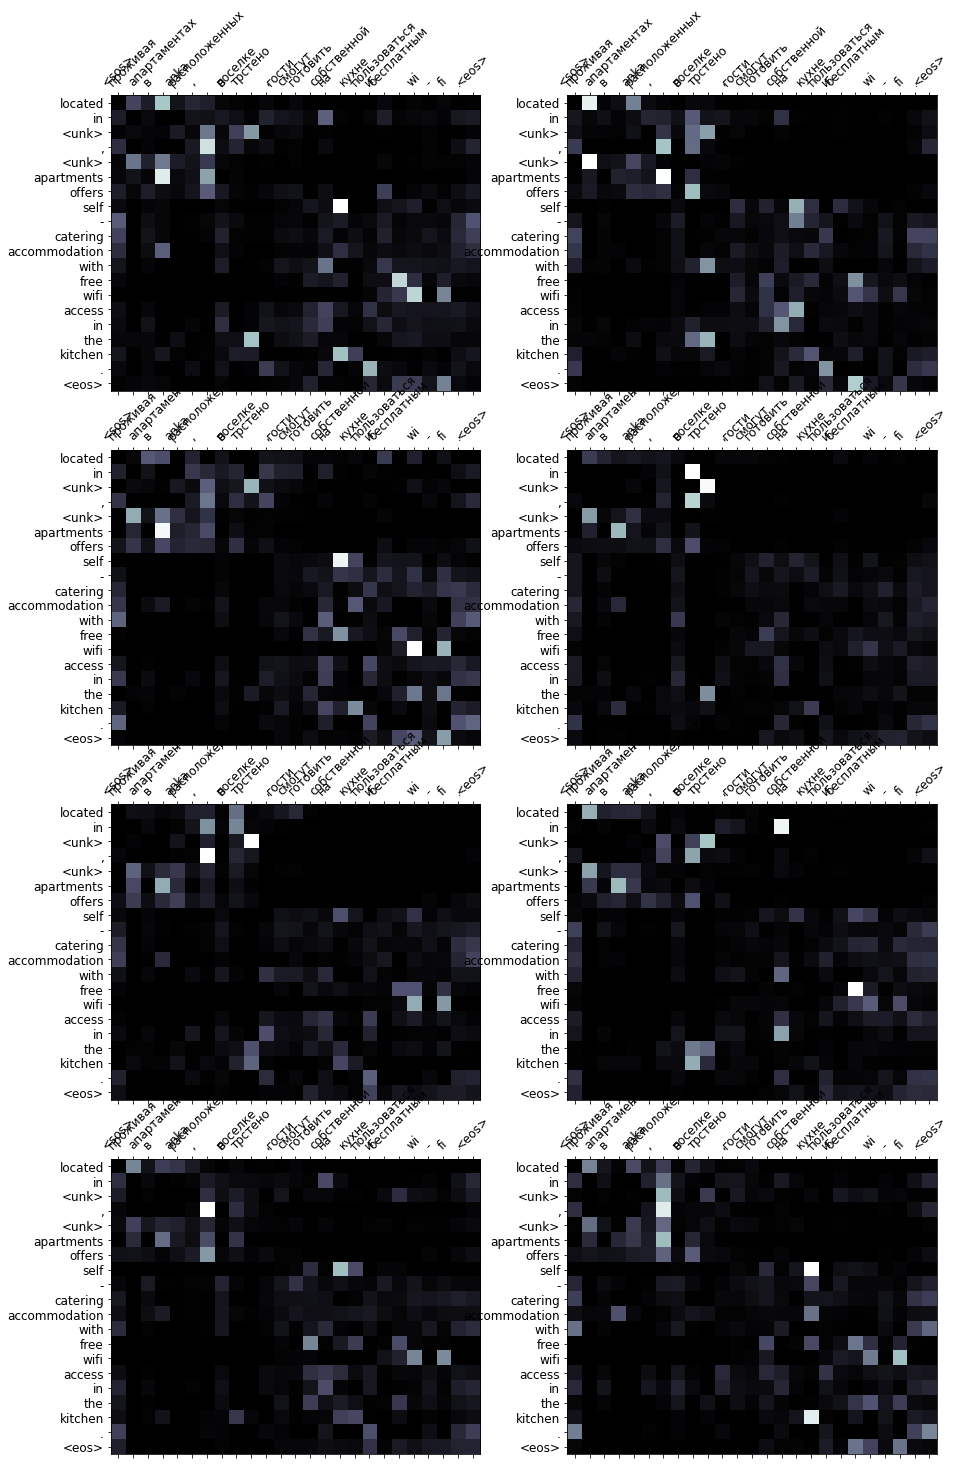

In [45]:
display_attention(src, translation, attention)

In [46]:
bleu = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu*100:.2f}')

BLEU score = 28.55


Порог в 25% преодолён

# 4. CNN-Encoder & CNN-Decoder

Т.к. мы использовали в энкодере и декодере реккурентные слои, то ради разнообразия посмотрим какой результат покажут сверточные слои

In [47]:
import cnn
Encoder = cnn.Encoder
Decoder = cnn.Decoder
Seq2Seq = cnn.Seq2Seq

In [48]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512
ENC_LAYERS = 10
DEC_LAYERS = 10
ENC_KERNEL_SIZE = 3
DEC_KERNEL_SIZE = 3
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [49]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 38,105,619 trainable parameters


In [50]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9233, 256)
    (pos_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,),

In [51]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

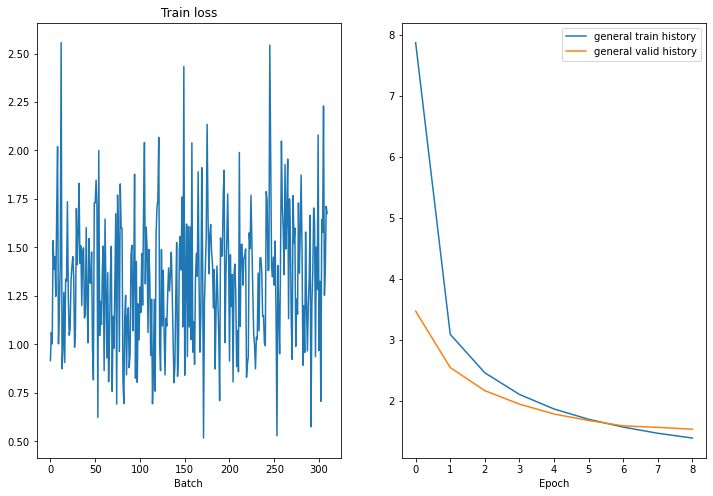

Epoch: 10 | Time: 2m 23s
	Train Loss: 1.326 | Train PPL:   3.768
	 Val. Loss: 1.504 |  Val. PPL:   4.500


In [52]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, True)
    valid_loss = evaluate(model, valid_iterator, criterion, True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cnn-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [54]:
for idx in [7,8]:

    src = vars(train_data.examples[idx])['src']
    trg = vars(train_data.examples[idx])['trg']
    translation, attention = translate_sentence(src, SRC, TRG, model, device, is_cnn=True)

    print(f"RUS: {' '.join(src)}")
    print(f"ENG: {' '.join(trg)}")
    print(f"Model: {' '.join(translation)}")
    print()

RUS: расстояние до популярного озера титизе составляет 35 км . на территории гостевого дома также обустроена бесплатная частная парковка .
ENG: the popular lake titisee is 35 km away , and free private parking is available on site .
Model: the popular lake <unk> is 35 km away and free private parking is available on site . <eos>

RUS: стойка регистрации отеля gran isabel riquelme открыта круглосуточно . работает экскурсионное бюро . осуществляется обмен валюты .
ENG: gran hotel isabel riquelme has a 24 - hour front desk , complete with a tour desk and currency exchange .
Model: gran isabel <unk> hotel you will find a 24 - hour front desk , a tour desk and currency exchange . <eos>



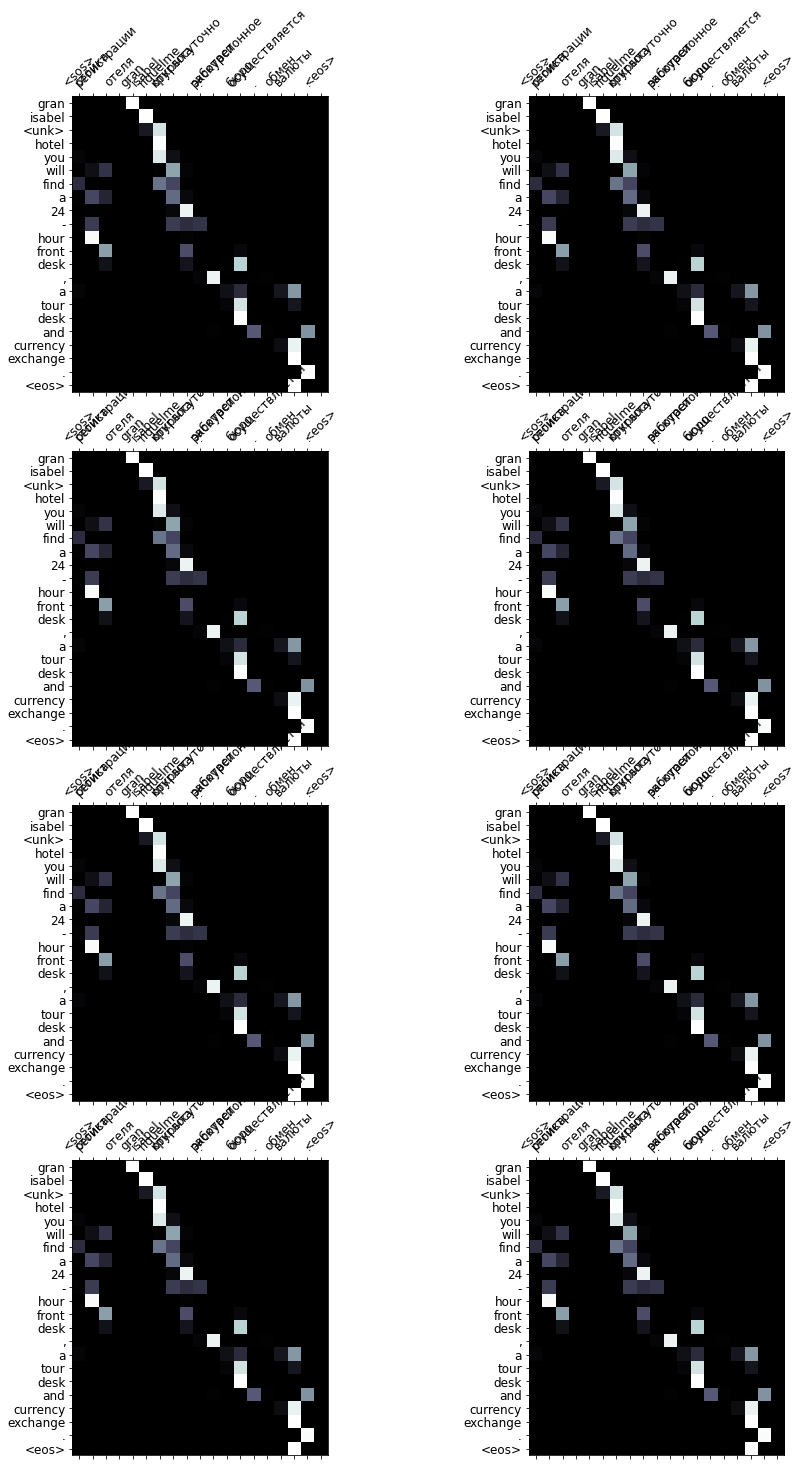

In [55]:
display_attention(src, translation, attention, is_cnn=True)

In [56]:
bleu = calculate_bleu(test_data, SRC, TRG, model, device, is_cnn=True)

print(f'BLEU score = {bleu*100:.2f}')

BLEU score = 30.48


Результат еще чуть-чуть улучшился

# Сравнение моделей:

Baseline:

BLEU: 12.45 %, время обучения: 17m 20s, кол-во параметров: 14,853,139

GRU + Attention:

BLEU: 22.72 %, время обучения: 20m 50s, кол-во параметров: 16,466,225

Transformer:

BLEU: 28.55 %, время обучения: 4m 50s, кол-во параметров: 9,792,787

CNN:

BLEU: 30.48 %, время обучения: 23m 50s, кол-во параметров: 38,105,619


Лучшее качество показывает CNN модель (можно объяснить большим числом обучаемых параметров), однако она обучается дольше всего. В соотношении качество/скорость обучения лучше всего себя показывает трансформер (он обучился очень быстро в сравнении с другими моделями, к тому же имеет меньше всего параметров, сказка).

Все модели были склонны к переобучению (т.к. лосс на валидации выходил на плато, а на трейне падал), однако две последние начинали переобучаться на последних эпохах, в отличии от первых двух 